# Import Library

In [1]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Concatenate, Attention, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from gensim.models import FastText
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from Levenshtein import distance as levenshtein_distance

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Understanding

In [4]:
''''
Get The Data
'''

data = drive.CreateFile({'id':'1ACNH6riCVczdndxwhfVL98UOuu_Fjndp'})
data.GetContentFile('Jawa-Sunda.csv')

In [5]:
df = pd.read_csv('Jawa-Sunda.csv')
df.head()

,language,pegon,latin
0,Jawa,تاريخ,tariḵ
1,Jawa,والى,wali
2,Jawa,سڠا,sṅa
3,Jawa,نࣤرَاڠَاكࣤنْ,něraṅakěn
4,Jawa,بَبَادْاِيْفُونْ,babadipun


In [6]:
df_sunda = df[df['language'] == 'Sunda']
df_sunda

,language,pegon,latin
1920,Sunda,اِيࣤ,iyě
1921,Sunda,بَابْ,bab
1922,Sunda,مࣤرْتَيْلَاكࣤنْ,měrtelakěn
1923,Sunda,تَصَوُّفْ,taṣawwup
1924,Sunda,اَنَسُ,anasu
...,...,...,...
6581,Sunda,مُوْلُسْ,mulus
6582,Sunda,ڠَمْفُوْرَا,ṅampura
6583,Sunda,إِصْلَاحْكࣤنْ,iṣlaẖkěn
6584,Sunda,ظَاهِرْ,ẕahir


In [7]:
'''
Split Train and Testing Data
'''

train_df, test_df = train_test_split(df_sunda, test_size=0.1, random_state=42)

print("Shape of training set:", train_df.shape)
print("Shape of testing set:", test_df.shape)

Shape of training set: (3692, 3)
Shape of testing set: (411, 3)


# Data Preprocessing

In [8]:
def preprocess(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: '\t' + str(x).lower() + '\n')
    return df

In [9]:
'''
Convert to Lower Case and Add Start and End Token of the Latin Words
'''

train_df = preprocess(train_df, 'latin')
train_df.head()

,language,pegon,latin
4385,Sunda,تَذَرُنَّ,\ttaḋarunna\n
4470,Sunda,قَوْمِكَ,\tqomika\n
5326,Sunda,ڮُسْتِيْ,\tgusti\n
1976,Sunda,مِسْكِينْ,\tmiskin\n
6473,Sunda,أَرَيْكْ,\tarek\n


In [10]:
def train_fasttext_model(sentences, window=7, vector_size=300, epochs=150, min_count=0, sg=1):
    model = FastText(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        epochs=epochs,
        min_count=min_count,
        sg=sg
    )
    return model

In [11]:
def create_tokenizer(column_data):
    # Create a tokenizer for character-level tokenization
    tokenizer = Tokenizer(char_level=True)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(column_data)

    return tokenizer

In [12]:
def create_input_sequences(column_data, tokenizer):
    # Get the size of the vocabulary (number of unique characters) plus one for padding
    char_size = len(tokenizer.word_index) + 1

    # Encode the text data into sequences of integers
    encoded = tokenizer.texts_to_sequences(column_data)

    # Find the maximum sequence length
    max_len = max(len(seq) for seq in encoded)

    # Pad the sequences to ensure uniform length
    padded = pad_sequences(encoded, maxlen=max_len, padding='post')

    return char_size, encoded, max_len, padded

In [13]:
# Create Pegon Character Tokenizer
pegon_tokenizer = create_tokenizer(train_df['pegon'])

# Create Latin Character Tokenizer
latin_tokenizer = create_tokenizer(train_df['latin'])

In [14]:
# Create Input Sequences of Pegon Words
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(train_df['pegon'], pegon_tokenizer)

# Create Input Sequences of Latin Words
latin_char_size, latin_encoded, latin_max_len, padded_latin = create_input_sequences(train_df['latin'], latin_tokenizer)

In [15]:
'''
Save Tokenizer
'''

filename = 'pegon_tokenizer.pkl'
pickle.dump(pegon_tokenizer, open(filename, 'wb'))

filename = 'latin_tokenizer.pkl'
pickle.dump(latin_tokenizer, open(filename, 'wb'))

In [16]:
'''
Latin Token Index
'''

latin_index = latin_tokenizer.word_index
latin_df = pd.DataFrame(list(latin_index.items()), columns=['Char', 'Index'])
latin_df.set_index('Char', inplace=True)
latin_df

,Index
Char,
a,1
\t,2
\n,3
n,4
i,5
u,6
r,7
l,8
t,9


In [17]:
'''
Pegon Token Index
'''

pegon_index = latin_tokenizer.word_index
pegon_df = pd.DataFrame(list(pegon_index.items()), columns=['Char', 'Index'])
pegon_df.set_index('Char', inplace=True)
pegon_df

,Index
Char,
a,1
\t,2
\n,3
n,4
i,5
u,6
r,7
l,8
t,9


In [18]:
'''
Check All of Variables
'''

print("Number of characters in Pegon:", pegon_char_size)
print("Number of characters in Latin:", latin_char_size)

print()

print("Example of Encoded Pegon:", pegon_encoded[0])
print("Example of Encoded Latin:", latin_encoded[0])

print()

print("Max Length of Encoded Pegon Sequences:", pegon_max_len)
print("Max Length of Encoded Latin Sequences", latin_max_len)


print()

print("Example of Encoded Pegon with Padding:", padded_pegon[0])
print("Example of Encoded Latin with Padding:", padded_latin[0])

Number of characters in Pegon: 55
Number of characters in Latin: 45

Example of Encoded Pegon: [12, 1, 41, 1, 10, 6, 4, 23, 1]
Example of Encoded Latin: [2, 9, 1, 35, 1, 7, 6, 4, 4, 1, 3]

Max Length of Encoded Pegon Sequences: 20
Max Length of Encoded Latin Sequences 18

Example of Encoded Pegon with Padding: [12  1 41  1 10  6  4 23  1  0  0  0  0  0  0  0  0  0  0  0]
Example of Encoded Latin with Padding: [ 2  9  1 35  1  7  6  4  4  1  3  0  0  0  0  0  0  0]


In [19]:
'''
Train fastText model both Latin and Pegon
'''

vector_size = 300

pegon_vectorizer = train_fasttext_model(df['pegon'], vector_size)
latin_vectorizer = train_fasttext_model(df['latin'], vector_size)

In [20]:
def create_embedding_matrix(tokenizer, vectorizer):
    # Initialize embedding matrix
    char_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((char_size, vectorizer.vector_size))

    # Fill embedding matrix
    for char, i in tokenizer.word_index.items():
        embedding_vector = vectorizer.wv[char]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [21]:
'''
Create the Embedding Matrix for both Pegon and Latin
'''

pegon_emb_mat = create_embedding_matrix(pegon_tokenizer, pegon_vectorizer)
latin_emb_mat = create_embedding_matrix(latin_tokenizer, latin_vectorizer)


print("Example of Pegon Embedding Matrix:\n", pegon_emb_mat)
print("Example of Latin Embedding Matrix:\n", latin_emb_mat)

Example of Pegon Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.02314892  0.10694028 -0.03076339 ... -0.06135215  0.07339098
  -0.07927954]
 [-0.02448495  0.08479991 -0.00269262 ...  0.00368729  0.04689692
  -0.09988353]
 ...
 [ 0.04484642  0.11883296 -0.16091529 ... -0.05846436 -0.35436621
   0.01019567]
 [-0.03030264 -0.05877337  0.2390902  ... -0.12643924 -0.12833567
   0.09360264]
 [-0.04100248 -0.02155888  0.10642973 ... -0.07828031  0.03214046
  -0.07027619]]
Example of Latin Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.04661631 -0.09495421 -0.00446652 ...  0.008837   -0.00811046
  -0.0075973 ]
 [-0.00063902  0.00246553 -0.00065751 ...  0.00165612  0.0028372
  -0.00297938]
 ...
 [ 0.00552661 -0.01955959 -0.21867409 ... -0.07523528  0.21566077
  -0.12111634]
 [ 0.06625669 -0.03484549  0.09241106 ...  0.01422643  0.29068309
  -0.09497835]
 [ 0.09374272  0.07680576 -0.0983181  ...  

# Modelling

In [22]:
'''
Split Train and Validation Data
'''

X_train, X_val, y_train, y_val = train_test_split(padded_pegon, padded_latin, test_size=0.1, random_state=42)

print("Shape of Pegon Train:", X_train.shape)
print("Shape of Latin Train:", y_train.shape)
print("Shape of Pegon Validation:", X_val.shape)
print("Shape of Latin Validation:", y_val.shape)

Shape of Pegon Train: (3322, 20)
Shape of Latin Train: (3322, 18)
Shape of Pegon Validation: (370, 20)
Shape of Latin Validation: (370, 18)


In [23]:
def compile_model(model):
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

In [24]:
def create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [25]:
def create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_outputs, forward_h, backward_h = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_outputs, _ = GRU(latent_dim*2, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [26]:
def create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [27]:
def create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, backward_h = encoder_gru(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [28]:
def train_model(model, X_train, X_val, y_train, y_val, epochs=100, batch_size=64, patience=5):
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]),
                        callbacks=[early_stopping])

    training_time_seconds = time.time() - start_time
    training_time_minutes = training_time_seconds / 60.0
    print(f"Training time: {training_time_minutes:.2f} minutes")

    return model, training_time_minutes, history

## Create Model

In [29]:
'''
Create bilstm_att Seq2Seq Model
'''

bilstm_att = create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bilstm_att.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 512)              28160     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 20, 1024),           4198400   ['embedding[0][0]']           
 al)                          (None, 512),                                                    

In [30]:
'''
Create bigru_att Seq2Seq Model
'''

bigru_att = create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bigru_att.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 20, 512)              28160     ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  [(None, 20, 1024),           3151872   ['embedding_2[0][0]']         
 onal)                        (None, 512),                                                  

In [31]:
'''
Create fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att = create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bilstm_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 20, 300)              16500     ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_2 (Bidirecti  [(None, 20, 1024),           3330048   ['embedding_4[0][0]']         
 onal)                        (None, 512),                                                  

In [32]:
'''
Create fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att = create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bigru_att.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 20, 300)              16500     ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  [(None, 20, 1024),           2500608   ['embedding_6[0][0]']         
 onal)                        (None, 512),                                                  

## Training Model

In [33]:
'''
Train bilstm_att Seq2Seq Model
'''

bilstm_att, bilstm_att_training_time, bilstm_att_history = train_model(bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 236s 4s/step - loss: 1.4315 - accuracy: 0.6430 - val_loss: 1.1179 - val_accuracy: 0.7057
Epoch 2/100
52/52 [==============================] - 213s 4s/step - loss: 0.9654 - accuracy: 0.7428 - val_loss: 0.7276 - val_accuracy: 0.8124
Epoch 3/100
52/52 [==============================] - 212s 4s/step - loss: 0.4414 - accuracy: 0.8945 - val_loss: 0.2342 - val_accuracy: 0.9490
Epoch 4/100
52/52 [==============================] - 209s 4s/step - loss: 0.1691 - accuracy: 0.9605 - val_loss: 0.2131 - val_accuracy: 0.9450
Epoch 5/100
52/52 [==============================] - 204s 4s/step - loss: 0.0930 - accuracy: 0.9784 - val_loss: 0.0827 - val_accuracy: 0.9816
Epoch 6/100
52/52 [==============================] - 205s 4s/step - loss: 0.0490 - accuracy: 0.9885 - val_loss: 0.0519 - val_accuracy: 0.9881
Epoch 7/100
52/52 [==============================] - 210s 4s/step - loss: 0.0403 - accuracy: 0.9909 - val_loss: 0.0627 - val_accuracy: 0.9870
Epoch 

In [34]:
'''
Train bigru_att Seq2Seq Model
'''

bigru_att, bigru_att_training_time, bigru_att_history = train_model(bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 135s 2s/step - loss: 1.4386 - accuracy: 0.6403 - val_loss: 1.0261 - val_accuracy: 0.7149
Epoch 2/100
52/52 [==============================] - 119s 2s/step - loss: 0.6784 - accuracy: 0.8289 - val_loss: 0.2743 - val_accuracy: 0.9388
Epoch 3/100
52/52 [==============================] - 108s 2s/step - loss: 0.1591 - accuracy: 0.9613 - val_loss: 0.0835 - val_accuracy: 0.9812
Epoch 4/100
52/52 [==============================] - 110s 2s/step - loss: 0.0599 - accuracy: 0.9859 - val_loss: 0.0475 - val_accuracy: 0.9901
Epoch 5/100
52/52 [==============================] - 114s 2s/step - loss: 0.0407 - accuracy: 0.9905 - val_loss: 0.0531 - val_accuracy: 0.9884
Epoch 6/100
52/52 [==============================] - 117s 2s/step - loss: 0.0384 - accuracy: 0.9913 - val_loss: 0.0300 - val_accuracy: 0.9946
Epoch 7/100
52/52 [==============================] - 118s 2s/step - loss: 0.0251 - accuracy: 0.9942 - val_loss: 0.0232 - val_accuracy: 0.9954
Epoch 

In [35]:
'''
Train fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history = train_model(fasttext_bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 137s 3s/step - loss: 1.5776 - accuracy: 0.6147 - val_loss: 1.2301 - val_accuracy: 0.6684
Epoch 2/100
52/52 [==============================] - 141s 3s/step - loss: 1.1453 - accuracy: 0.6922 - val_loss: 1.0333 - val_accuracy: 0.7176
Epoch 3/100
52/52 [==============================] - 144s 3s/step - loss: 0.9372 - accuracy: 0.7388 - val_loss: 0.8545 - val_accuracy: 0.7622
Epoch 4/100
52/52 [==============================] - 131s 3s/step - loss: 0.7433 - accuracy: 0.7941 - val_loss: 0.6018 - val_accuracy: 0.8326
Epoch 5/100
52/52 [==============================] - 132s 3s/step - loss: 0.4534 - accuracy: 0.8825 - val_loss: 0.3128 - val_accuracy: 0.9221
Epoch 6/100
52/52 [==============================] - 126s 2s/step - loss: 0.2442 - accuracy: 0.9372 - val_loss: 0.1904 - val_accuracy: 0.9558
Epoch 7/100
52/52 [==============================] - 130s 3s/step - loss: 0.1192 - accuracy: 0.9732 - val_loss: 0.0952 - val_accuracy: 0.9779
Epoch 

In [36]:
'''
Train fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history = train_model(fasttext_bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 110s 2s/step - loss: 1.5249 - accuracy: 0.6345 - val_loss: 1.1479 - val_accuracy: 0.6935
Epoch 2/100
52/52 [==============================] - 100s 2s/step - loss: 1.0514 - accuracy: 0.7119 - val_loss: 1.0032 - val_accuracy: 0.7126
Epoch 3/100
52/52 [==============================] - 102s 2s/step - loss: 0.7114 - accuracy: 0.8163 - val_loss: 0.3936 - val_accuracy: 0.9129
Epoch 4/100
52/52 [==============================] - 101s 2s/step - loss: 0.2327 - accuracy: 0.9450 - val_loss: 0.1565 - val_accuracy: 0.9639
Epoch 5/100
52/52 [==============================] - 99s 2s/step - loss: 0.0859 - accuracy: 0.9815 - val_loss: 0.0765 - val_accuracy: 0.9846
Epoch 6/100
52/52 [==============================] - 101s 2s/step - loss: 0.0546 - accuracy: 0.9879 - val_loss: 0.0595 - val_accuracy: 0.9876
Epoch 7/100
52/52 [==============================] - 102s 2s/step - loss: 0.0444 - accuracy: 0.9900 - val_loss: 0.0361 - val_accuracy: 0.9922
Epoch 8

# Model Evaluation

In [37]:
def evaluate_model(model, X_val, y_val):
    evaluation_result = model.evaluate([X_val, y_val[:, :-1]], y_val[:, 1:])
    loss = evaluation_result[0]
    accuracy = evaluation_result[1]

    return loss, accuracy

In [38]:
'''
Evaluate Model
'''

models = {
    'bilstm_att': [bilstm_att, bilstm_att_training_time, bilstm_att_history],
    'bigru_att': [bigru_att, bigru_att_training_time, bigru_att_history],
    'fasttext_bilstm_att': [fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history],
    'fasttext_bigru_att': [fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history]
}

evaluation_results = []

for model_name, values in models.items():
    model = values[0]
    training_time = values[1]
    history = values[2]
    loss, accuracy = evaluate_model(model, X_val, y_val)
    evaluation_results.append({
        'Model': model_name,
        'Loss': loss,
        'Accuracy': accuracy,
        'Epochs' : len(history.history['loss']),
        'Avg Training Time (m)': round(training_time/len(history.history['loss']), 2),
        'Total Training Time (m)': round(training_time, 2)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

12/12 [==============================] - 3s 280ms/step - loss: 0.0213 - accuracy: 0.9960


,Model,Loss,Accuracy,Epochs,Avg Training Time (m),Total Training Time (m)
0,bilstm_att,0.018293,0.996502,25,3.23,80.70
1,bigru_att,0.023215,0.995390,12,2.00,24.05
2,fasttext_bilstm_att,0.024287,0.995072,24,2.30,55.24
3,fasttext_bigru_att,0.021341,0.996025,21,1.73,36.32


In [39]:
def plot_loss_accuracy(model_name, history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history.get('val_loss', None)
    val_accuracy = history.history.get('val_accuracy', None)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(model_name + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

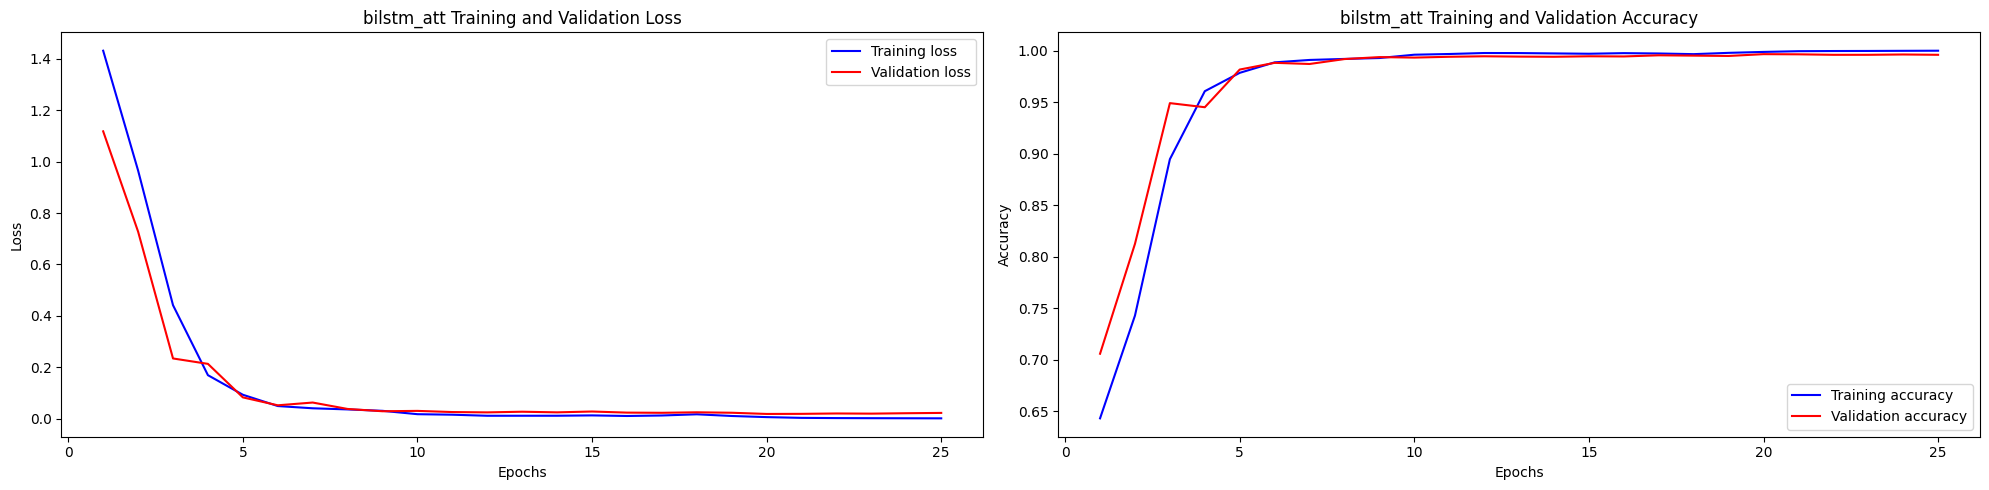

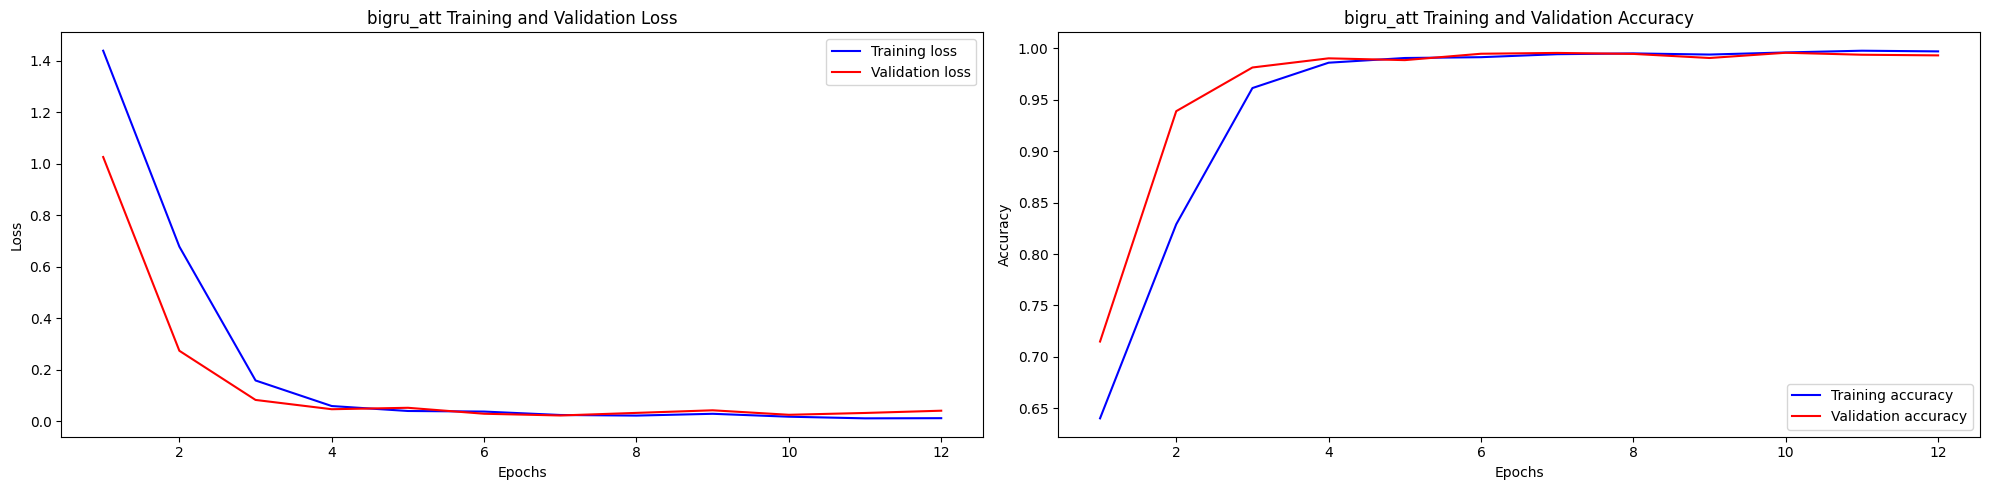

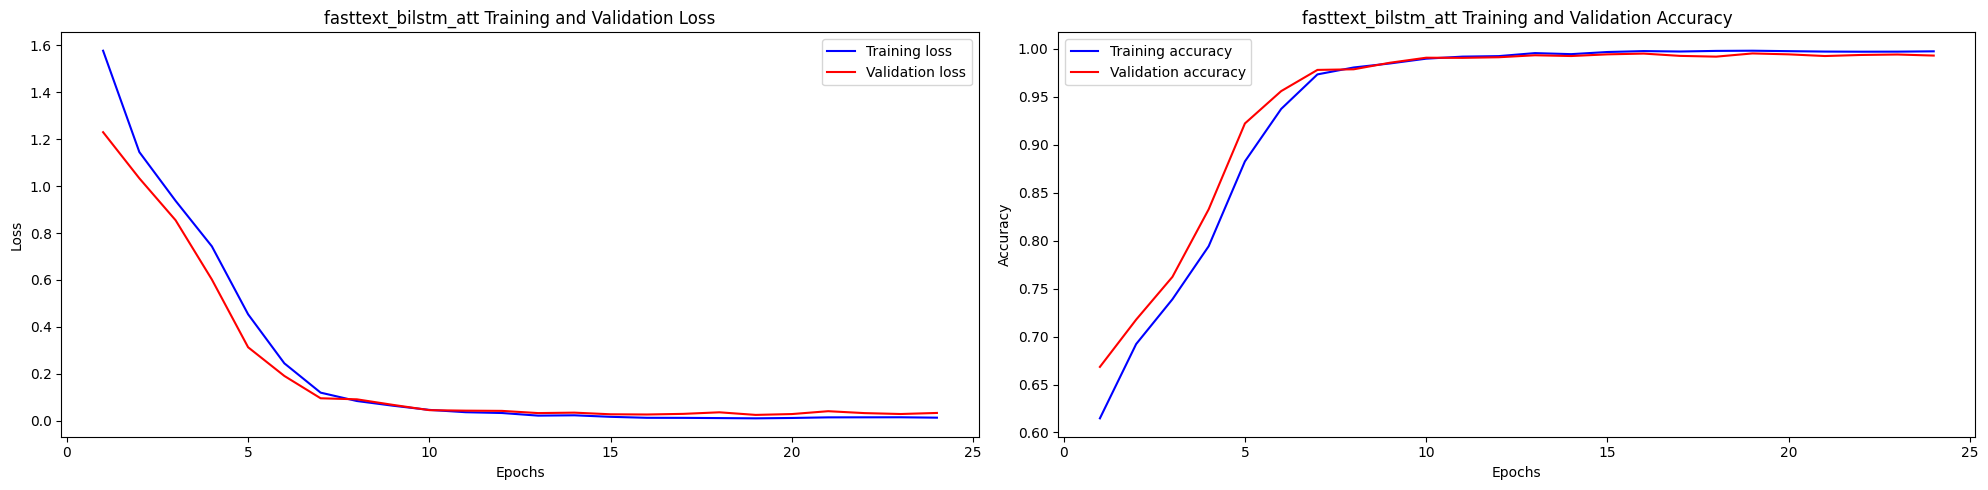

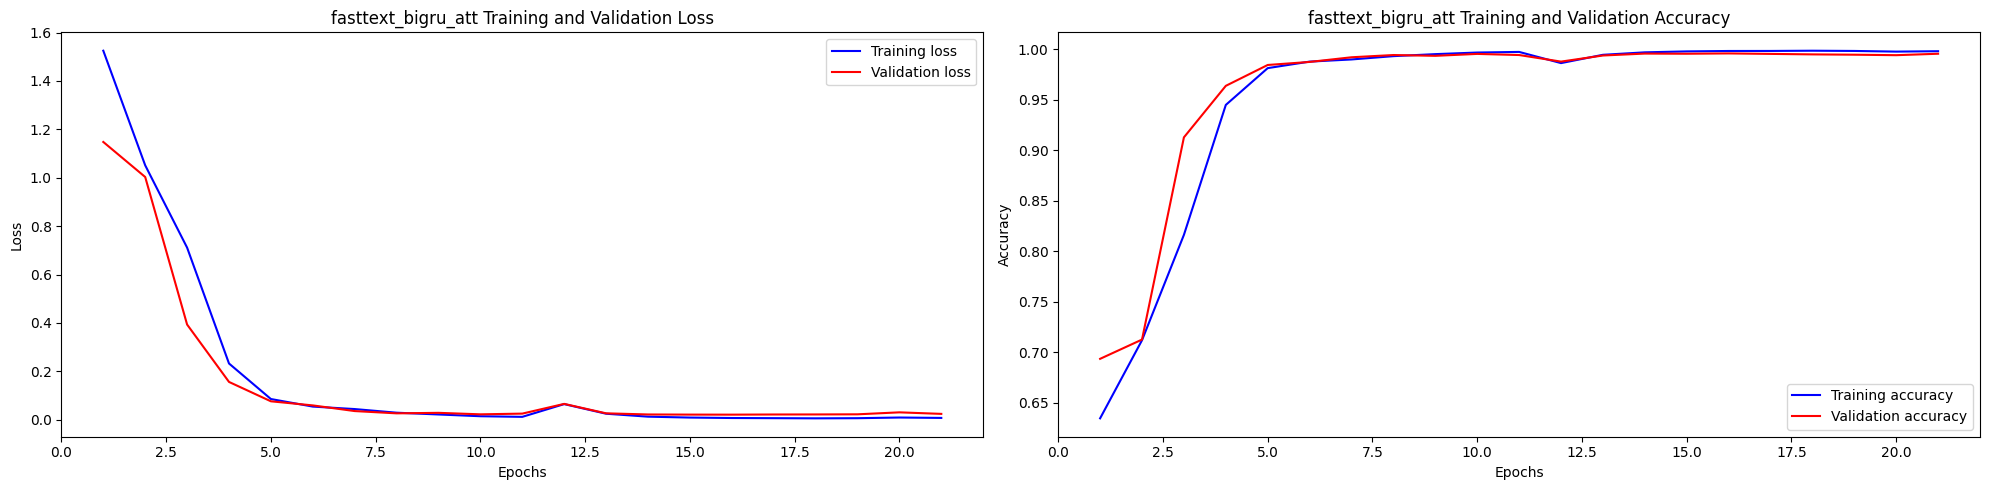

In [40]:
'''
Plot Accuracy and Loss
'''

histories = {
    'bilstm_att': bilstm_att_history,
    'bigru_att': bigru_att_history,
    'fasttext_bilstm_att': fasttext_bilstm_att_history,
    'fasttext_bigru_att': fasttext_bigru_att_history
}

for model_name, history in histories.items():
    plot_loss_accuracy(model_name, history)

In [41]:
'''
Save model
'''

filename = 'fasttext_bilstm_att.pkl'
pickle.dump(fasttext_bilstm_att, open(filename, 'wb'))

filename = 'fasttext_bigru_att.pkl'
pickle.dump(fasttext_bigru_att, open(filename, 'wb'))

filename = 'bilstm_att.pkl'
pickle.dump(bilstm_att, open(filename, 'wb'))

filename = 'bigru_att.pkl'
pickle.dump(bigru_att, open(filename, 'wb'))

In [42]:
def decode_output(decoder_input, tokenizer):
    output_seq = decoder_input[0, 1:-1]
    predicted_text = ""
    for index in output_seq:
        if index == 0:
            continue
        predicted_char = tokenizer.index_word.get(index, '')
        if predicted_char != ' ':
            predicted_text += predicted_char
    return predicted_text

In [43]:
def predict_latin(input_sequences, model, pegon_tokenizer, latin_tokenizer , pegon_max_length, latin_max_length):
    predictions = []
    for input_sequence in input_sequences:
        encoder_input = np.array([input_sequence])
        decoder_input = np.zeros((1, latin_max_length))
        decoder_input[0, 0] = latin_tokenizer.word_index['\t']

        for i in range(1, latin_max_length):
            pred = model.predict([[encoder_input], decoder_input], verbose=0)[0]
            predicted_token_index = np.argmax(pred[i-1])
            decoder_input[0, i] = predicted_token_index
            if predicted_token_index == latin_tokenizer.word_index['\n']:
                break

        predicted_text = decode_output(decoder_input, latin_tokenizer)
        predictions.append(predicted_text)
    return predictions

In [44]:
'''
Predict Data Train
'''

fasttext_bilstm_att_pred = predict_latin(X_val, fasttext_bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
fasttext_bigru_att_pred = predict_latin(X_val, fasttext_bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bilstm_att_pred = predict_latin(X_val, bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bigru_att_pred = predict_latin(X_val, bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

# Error Analysis

In [45]:
'''
Get The Latin and Pegon of Data Train
'''

pegon_train, pegon_test, latin_train, latin_test = train_test_split(train_df['pegon'], train_df['latin'], test_size=0.1, random_state=42)

In [46]:
def calculate_cer(row):
    # Calculate Levenshtein distance between Ground Truth and Predicted strings
    distance = levenshtein_distance(row['Ground Truth'], row['Predicted'])

    # Calculate the length of the target (Ground Truth) string
    length = len(row['Ground Truth'])

    # Calculate CER (Character Error Rate) and handle the case when the length is 0
    return distance / length if length > 0 else np.nan

In [47]:
def create_cer_analysis(result_df):
    # Remove '\n' and '\t' from the dataframe
    result_df = result_df.replace(r'\n', '', regex=True).replace(r'\t', '', regex=True)

    # Calculate CER for each row
    result_df['CER'] = result_df.apply(calculate_cer, axis=1)

    # Calculate mean CER
    cer_mean = result_df['CER'].mean()

    # Filter rows with CER > 0
    error_result = result_df[result_df['CER'] > 0]

    return result_df, cer_mean, error_result

## BiLSTM-Att

In [48]:
'''
Calculate CER
'''

bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bilstm_att_pred
})

bilstm_att_result, bilstm_att_cer, bilstm_att_error_result = create_cer_analysis(bilstm_att_result)

print("Average CER: " + str(bilstm_att_cer))

Average CER: 0.009635349635349635


In [49]:
'''
Prediction Result
'''

bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
2481,كُفُرْ,kupur,kupur,0.0
3978,أَحَدٍ,aẖadin,aẖadin,0.0
3647,وَّ,wwa,wwa,0.0
4579,تَكُنْ,takun,takun,0.0
2130,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
2242,سَلَهْنَا,salahna,salahna,0.0
5442,فِتُودُهْ,pituduh,pituduh,0.0
4349,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
6206,ۑَوْبِيْ,ñobi,ñobi,0.0


In [50]:
'''
Error Result
'''

bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
4607,بَيْنَهُمَا,benahuma,bainahuma,0.250000
4452,وَلِلْمُؤْمِنِيْنَ,walilmu`minina,walimmu`minina,0.071429
4230,مُنَاجَةْ,munajanat,munajat,0.222222
5414,سريرَيْيَا,srirea,srerea,0.166667
5416,برهلا,brhala,brhla,0.166667
3458,لِيَسْكُنَ,liyaskuna,liaskuna,0.111111
3678,أَوْفَتْ,opat,aupat,0.500000
4893,لِيُنْذِرَكُمْ,liyunḋirokum,liyunḋirakum,0.083333
3835,جَزَاءُ,jazau,jaza`u,0.200000
5527,مَيْڮَاوَيْ,migawe,megawe,0.166667


## BiGRU-Att

In [51]:
bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bigru_att_pred
})

bigruatt_result, bigru_att_cer, bigru_att_error_result = create_cer_analysis(bigru_att_result)

print("Average CER: " + str(bigru_att_cer))

Average CER: 0.012076020826020826


In [52]:
'''
Prediction Result
'''

bigruatt_result

,Pegon,Ground Truth,Predicted,CER
2481,كُفُرْ,kupur,kupur,0.0
3978,أَحَدٍ,aẖadin,aẖadin,0.0
3647,وَّ,wwa,wwa,0.0
4579,تَكُنْ,takun,takun,0.0
2130,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
2242,سَلَهْنَا,salahna,salahna,0.0
5442,فِتُودُهْ,pituduh,pituduh,0.0
4349,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
6206,ۑَوْبِيْ,ñobi,ñobi,0.0


In [53]:
'''
Error Result
'''

bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
4525,جَآءَ,jāa,jaāa,0.333333
3948,سُلَيْمَانَ,sulaimana,sulaymana,0.111111
5461,كَاڮَوكْ,kagok,kagawk,0.400000
4452,وَلِلْمُؤْمِنِيْنَ,walilmu`minina,walilmu`mininina,0.142857
4230,مُنَاجَةْ,munajanat,munajat,0.222222
5287,أُحِبُّ,uẖibbu,uẖibu,0.166667
5416,برهلا,brhala,brahla,0.333333
2562,كَلَكُوَانَنَا,kalakuanana,kalakuana,0.181818
2452,الصَّالِحُ,aṣ-ṣaliẖu,aṣṣaliẖu,0.111111
4893,لِيُنْذِرَكُمْ,liyunḋirokum,liyunḋirakum,0.083333


## fastText BiLSTM-Att

In [54]:
fasttext_bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bilstm_att_pred
})

fasttext_bilstm_att_result, fasttext_bilstm_att_cer, fasttext_bilstm_att_error_result = create_cer_analysis(fasttext_bilstm_att_result)

print("Average CER: " + str(fasttext_bilstm_att_cer))

Average CER: 0.010949260949260946


In [55]:
'''
Prediction Result
'''

fasttext_bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
2481,كُفُرْ,kupur,kupur,0.0
3978,أَحَدٍ,aẖadin,aẖadin,0.0
3647,وَّ,wwa,wwa,0.0
4579,تَكُنْ,takun,takun,0.0
2130,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
2242,سَلَهْنَا,salahna,salahna,0.0
5442,فِتُودُهْ,pituduh,pituduh,0.0
4349,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
6206,ۑَوْبِيْ,ñobi,ñobi,0.0


In [56]:
'''
Error Result
'''

fasttext_bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
2308,تَوْبَةْ,tobat,tobah,0.200000
4889,جَاءَكُمْ,jaakum,ja`akum,0.166667
4525,جَآءَ,jāa,jaāa,0.333333
3948,سُلَيْمَانَ,sulaimana,sulemana,0.222222
4513,ڠَاؼࣤهْؼࣤيْكࣤنْ,ṅagěhgěikěn,ṅagěhgěkěn,0.090909
4230,مُنَاجَةْ,munajanat,munajat,0.222222
6306,ڮُيُوْرْ,guyur,guur,0.200000
4080,مِّثْلَنَا,mmiṫlana,miṫlana,0.125000
5416,برهلا,brhala,brhl,0.333333
6081,ۑُهُوْنْكࣤنْ,ñuhunkěn,ñuunkěn,0.125000


## fastText BiGRU-Att

In [57]:
fasttext_bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bigru_att_pred
})

fasttext_bigruatt_result, fasttext_bigru_att_cer, fasttext_bigru_att_error_result = create_cer_analysis(fasttext_bigru_att_result)

print("Average CER: " + str(fasttext_bigru_att_cer))

Average CER: 0.0111494773994774


In [58]:
'''
Prediction Result
'''

fasttext_bigruatt_result

,Pegon,Ground Truth,Predicted,CER
2481,كُفُرْ,kupur,kupur,0.0
3978,أَحَدٍ,aẖadin,aẖadin,0.0
3647,وَّ,wwa,wwa,0.0
4579,تَكُنْ,takun,takun,0.0
2130,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
2242,سَلَهْنَا,salahna,salahna,0.0
5442,فِتُودُهْ,pituduh,pituduh,0.0
4349,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
6206,ۑَوْبِيْ,ñobi,ñobi,0.0


In [59]:
'''
Error Result
'''

fasttext_bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
4525,جَآءَ,jāa,jaāa,0.333333
3948,سُلَيْمَانَ,sulaimana,sulemana,0.222222
4452,وَلِلْمُؤْمِنِيْنَ,walilmu`minina,walimmu`mina,0.214286
4513,ڠَاؼࣤهْؼࣤيْكࣤنْ,ṅagěhgěikěn,ṅagěhgěn,0.272727
4230,مُنَاجَةْ,munajanat,munajat,0.222222
5414,سريرَيْيَا,srirea,sireya,0.333333
5416,برهلا,brhala,bihla,0.333333
5412,فنجوڠ,pnjuṅ,pnoṅ,0.400000
4893,لِيُنْذِرَكُمْ,liyunḋirokum,liyunḋirakum,0.083333
5555,مࣤلࣤكࣤتࣤكْتࣤكْ,mělěkětěktěk,mělěkěttěk,0.166667


## CER Compare

In [60]:
cer_result = pd.DataFrame({
    'Model': ['bilstm_att', 'bigru_att', 'fasttext_bilstm_att', 'fasttext_bigru_att'],
    'CER': [bilstm_att_cer, bigru_att_cer, fasttext_bilstm_att_cer, fasttext_bigru_att_cer]
})

cer_result

,Model,CER
0,bilstm_att,0.009635
1,bigru_att,0.012076
2,fasttext_bilstm_att,0.010949
3,fasttext_bigru_att,0.011149


# Model Testing

In [61]:
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(test_df['pegon'], pegon_tokenizer)

In [62]:
best_model = bigru_att
pred = predict_latin(padded_pegon, best_model, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

In [63]:
result = pd.DataFrame({
    'Pegon': test_df['pegon'],
    'Ground Truth': test_df['latin'],
    'Predicted': pred
})

model_result, model_cer, model_error_result = create_cer_analysis(result)

print("Average CER: " + str(model_cer))

Average CER: 0.02550636711220653


In [64]:
model_result

,Pegon,Ground Truth,Predicted,CER
3778,فَلَيْنَا,palaina,palena,0.285714
6324,دَوْمْبَا,domba,domba,0.000000
4941,تࣤفَنْتࣤسْ,těpantěs,těpantěs,0.000000
5438,مُوجَا,muja,muja,0.000000
6198,سَبِيْلًا,sabilan,sabilan,0.000000
...,...,...,...,...
5103,فَدَ,pada,pada,0.000000
5341,لِيْلِنْدࣤكْ,lilinděk,lilinděk,0.000000
2183,اُوْلَهْ,ulah,ulah,0.000000
4315,كࣤبَوْنْ,kěbon,kěbon,0.000000


In [65]:
model_error_result

,Pegon,Ground Truth,Predicted,CER
3778,فَلَيْنَا,palaina,palena,0.285714
3878,سَوْءَةَ,sau`ata,soata,0.428571
2029,خبل,ḵbl,ḵill,0.666667
5818,إِلَيْهِمْ,ilaihim,ilehim,0.285714
1928,اَلْحمْدُلِلّٰهِ,al-ẖamdulillāhi,al-ẖululāhi,0.333333
6116,كَعْبَةْ,ka'bah,ka'bat,0.166667
3244,تَاسِيكْمَلَايَا,tasikmalaya,tasikmala,0.181818
2069,لِّيُرَوْا,lliyurau,lliuro,0.375000
5815,أَفْئِدَةً,apidatan,apaidatan,0.125000
1990,حُسَيْنُ,ẖusainu,ẖusenu,0.285714
